In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# additional imports
import pandas as pd
import seaborn as sns
from pandas import read_pickle

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [ ]:
df = pd.read_pickle('path/Dataset/New_Preprocessed_Dataset.pkl')

In [3]:
# rename label : none to normal
df['label'] = df['label'].replace('none', 'normal')

In [ ]:
embeddings = np.array(df['embedding'].tolist())
labels = df['label'].tolist() 

In [5]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)

In [ ]:
pd.Series(y_test).value_counts()  

normal    3116
sexism     977
racism     590
Name: count, dtype: int64

### SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [8]:
print("Distribution après SMOTE :", dict(zip(*np.unique(y_train_sm, return_counts=True))))

Distribution après SMOTE : {'normal': 7271, 'racism': 7271, 'sexism': 7271}


### RandomOverSampling

In [9]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [10]:
print("Distribution après ROS :", dict(zip(*np.unique(y_train_ros, return_counts=True))))

Distribution après ROS : {'normal': 7271, 'racism': 7271, 'sexism': 7271}


### GAN

In [ ]:
df_gan = read_pickle('path/Dataset/GAN_DF.pkl')

# remove 10 sexism samples
df_gan = df_gan.drop(df_gan[df_gan["label"] == "sexism"].sample(n=10, random_state=42).index)

# merge df_gan and x train and y train
X_train_gan = np.concatenate((X_train, df_gan['embedding'].tolist()), axis=0)
y_train_gan = np.concatenate((y_train, df_gan['label'].tolist()), axis=0)

In [12]:
print("Distribution après GAN :", dict(zip(*np.unique(y_train_gan, return_counts=True))))

Distribution après GAN : {'normal': 7271, 'racism': 2875, 'sexism': 7271}


## Random Forest

In [ ]:
def train_rf_with_gridsearch(X_train, y_train, cv=None):
    # grid search parameters
    param_grid_rf = {
        'n_estimators': [50],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }

    rf_classifier = RandomForestClassifier(random_state=42)

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV
    grid_search_rf = GridSearchCV(
        rf_classifier,
        param_grid=param_grid_rf,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    # training
    grid_search_rf.fit(X_train, y_train)

    return grid_search_rf


In [ ]:
def evaluate_model(grid_search, X_test, y_test, label="Model", cmap="Blues", class_names=["normal", "racism", "sexism"]):

    # Get the best classifier from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_clf.predict(X_test)

    # Automatically infer class names if not provided
    if class_names is None:
        class_names = sorted(np.unique(y_test))

    # Compute performance metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    recall = round(recall_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted', zero_division=0), 2)

    print(f"\n--- Results for {label} ---")

    # Raw confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    print("Confusion matrix:")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({label})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Percentage confusion matrix
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({label}) - Percentages (%)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Print classification report
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=class_names))

    # Print summary metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Best parameters found:", grid_search.best_params_)

    return best_clf


Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF with SMOTE ---
Confusion matrix:


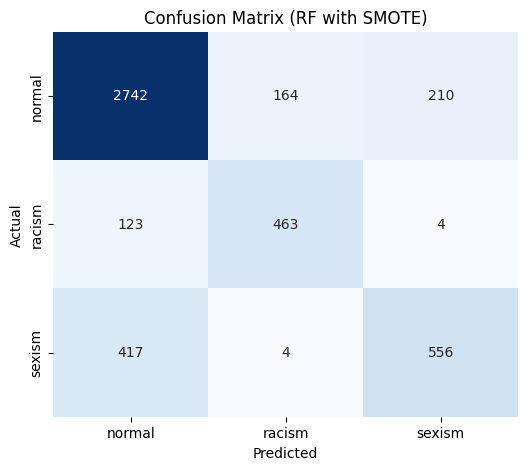

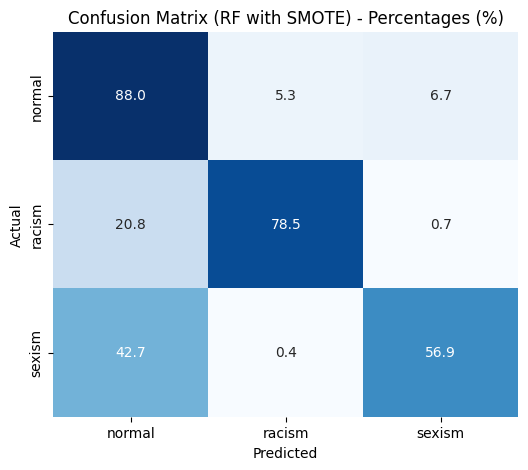


Classification report:
              precision    recall  f1-score   support

      normal       0.84      0.88      0.86      3116
      racism       0.73      0.78      0.76       590
      sexism       0.72      0.57      0.64       977

    accuracy                           0.80      4683
   macro avg       0.76      0.74      0.75      4683
weighted avg       0.80      0.80      0.80      4683

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1-Score: 0.8
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, random_state=42)

In [15]:
grid_search_smote = train_rf_with_gridsearch(X_train_sm, y_train_sm)
evaluate_model(grid_search_smote, X_test, y_test, label="RF with SMOTE")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF with ROS ---
Confusion matrix:


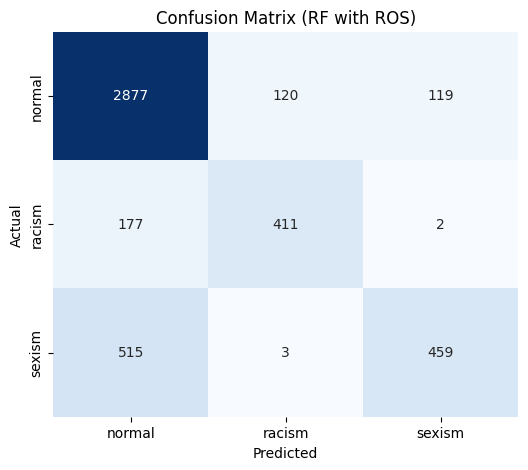

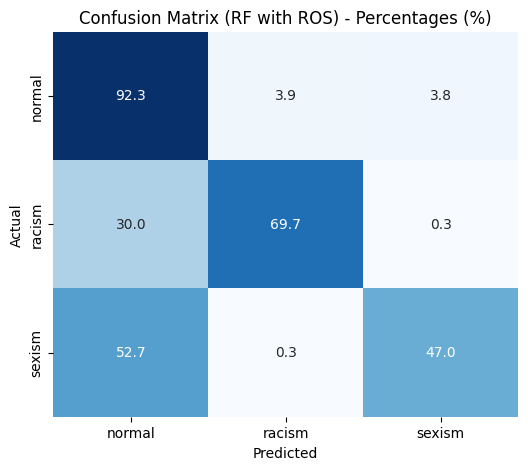


Classification report:
              precision    recall  f1-score   support

      normal       0.81      0.92      0.86      3116
      racism       0.77      0.70      0.73       590
      sexism       0.79      0.47      0.59       977

    accuracy                           0.80      4683
   macro avg       0.79      0.70      0.73      4683
weighted avg       0.80      0.80      0.79      4683

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1-Score: 0.79
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, random_state=42)

In [16]:
grid_search_ros = train_rf_with_gridsearch(X_train_ros, y_train_ros)
evaluate_model(grid_search_ros, X_test, y_test, label="RF with ROS")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF with GAN ---
Confusion matrix:


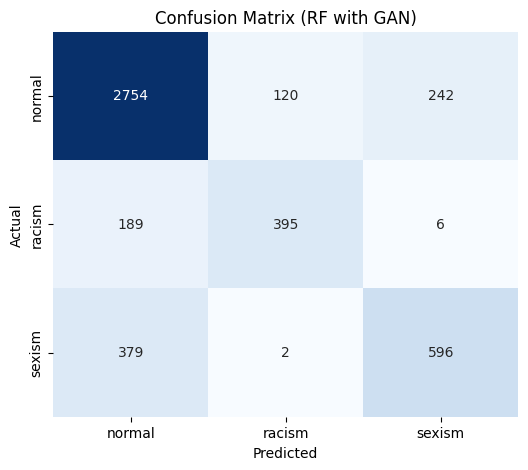

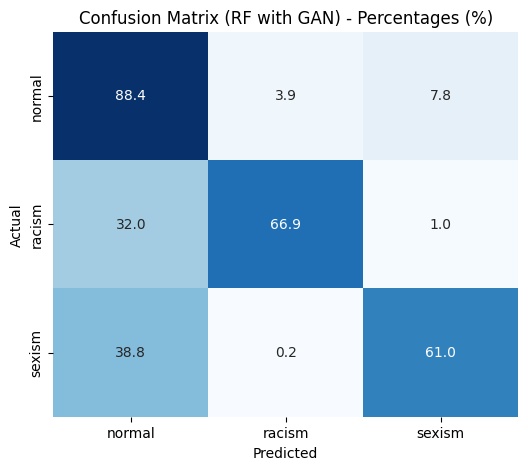


Classification report:
              precision    recall  f1-score   support

      normal       0.83      0.88      0.86      3116
      racism       0.76      0.67      0.71       590
      sexism       0.71      0.61      0.65       977

    accuracy                           0.80      4683
   macro avg       0.77      0.72      0.74      4683
weighted avg       0.80      0.80      0.80      4683

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1-Score: 0.8
Best parameters found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42)

In [17]:
grid_search_gan = train_rf_with_gridsearch(X_train_gan, y_train_gan)
evaluate_model(grid_search_gan, X_test, y_test, label="RF with GAN")

### 

### Without Augmentation

Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF without augmentation ---
Confusion matrix:


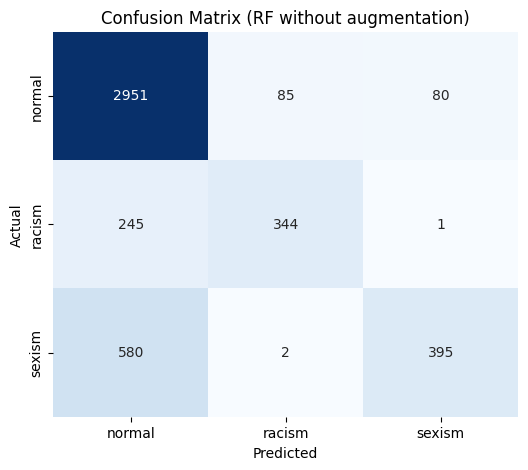

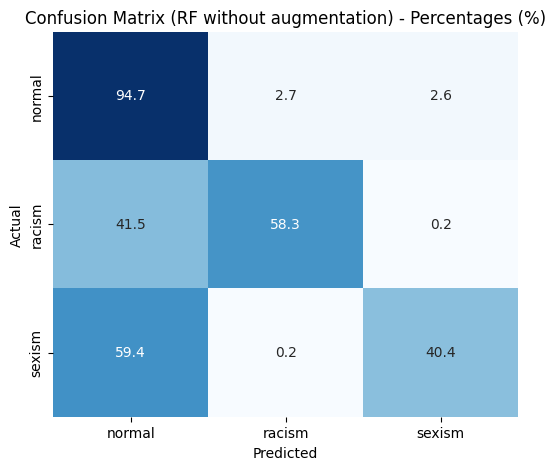


Classification report:
              precision    recall  f1-score   support

      normal       0.78      0.95      0.86      3116
      racism       0.80      0.58      0.67       590
      sexism       0.83      0.40      0.54       977

    accuracy                           0.79      4683
   macro avg       0.80      0.64      0.69      4683
weighted avg       0.79      0.79      0.77      4683

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F1-Score: 0.77
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, random_state=42)

In [18]:
grid_search_no = train_rf_with_gridsearch(X_train, y_train)
evaluate_model(grid_search_no, X_test, y_test, label="RF without augmentation")